# SMS Message Spam filter.
This project is designed to explore the practical side of the algorithm by building a spam filter for SMS messages. To classify messages as 'spam' or 'non-spam' we need to ensure that our computer:
1. Learns how humans classify messages.
2. Uses that human knowledge to estimate probabilities for new messages - probabilities for spam and non-spam.
3. Classifies a new message based on these probability values - if the probability for the spam is greater,  then it classifies the message as spam. Otherwise, it classifies it as non-spam (if the two probability values are equal, the we may need a human to classify the message).

So our first task is to "teach" the computer how to classify messages. To do that, we'll use the multinomial Naive Bayes algorithm along with a dataset of 5,572 SMS messages that are already classified by humans.

In [19]:
#Reading csv file into a dataset using Pandas.
import pandas as pd
SMS = pd.read_csv('SMSSpamCollection', sep='\t', 
               header=None, names=['Label','SMS'])

#Exploring the dataset to familiarize myself with it.
print('Rows: ',SMS.shape[0])
print('Columns: ',SMS.shape[1])

#Finding out what percentages of the messages is spam and what percentage is ham(Non-spam)
print(round(SMS['Label'].value_counts(normalize=True)*100,2),'%')
SMS.head()

Rows:  5572
Columns:  2
ham     86.59
spam    13.41
Name: Label, dtype: float64 %


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


So about 87% of the messages are ham(non-spam) and the remaining 13% are spam. Now that I'm familiar with the dataset, I can move on building the spam filter. 

But before creating it, it's very helpful to first think of a way of testing how well it works. When creating this software, the general rule of thumb is to design the test before creating the software in order to prevent myself from coming up with biased tests just to make sure that the software passe it.

Once the spam-filter is complete, we'll need to test how well it can classify new messages. TO test the filter, we're first going to split our dataset into two categories:
- A training set which we'll use to "train" the computer how to classify messages.
- A test set which we'll use to test how good the spam filter is with classifying new messages.

80% of the dataset will be used for training, and the remaining 20 will be used for testing. Since the dataset contains 5,572 messages:
- 4,458 messages (about 80%) of those messages will be for training.
- 1,114 messages (about 20%) of those messages will be for testing.

I'll start by analyzing the 1,114 messages. My goal in this project is to correctly classify our spam filter with an accuracy greater than 80%. This means that I want my spam filter to correctly classify more than 80% of all the new messages as spam or ham correctly.

In [36]:
#First we'll need to randomize the dataset.
randomized_data = SMS.sample(frac=1, random_state=1) #frac=1 to randomize the entire dataset and random_state=1 
                                    #to make sure my results were reproducible.

#Seperating dataset between training and testing.
train_data_index = round(len(randomized_data)*0.8)
train_data = randomized_data[:train_data_index].reset_index(drop=True)
test_data = randomized_data[train_data_index:].reset_index(drop=True)


print('Train Dataset \n', '# of Rows: ', train_data.shape[0],'\n','# of Columns: ',train_data.shape[1])
print('\n')
print('Test Dataset \n', '# of Rows: ', test_data.shape[0],'\n','# of Columns: ',test_data.shape[1])


Train Dataset 
 # of Rows:  4458 
 # of Columns:  2


Test Dataset 
 # of Rows:  1114 
 # of Columns:  2


In [21]:
round(train_data['Label'].value_counts(normalize=True)*100,2)

ham     86.54
spam    13.46
Name: Label, dtype: float64

In [22]:
round(test_data['Label'].value_counts(normalize=True)*100,2)

ham     86.8
spam    13.2
Name: Label, dtype: float64

The percentages in both datasets appear to be similar than the percentages in the original SMS dataset.

# Utilizing the Naive Bayes Theorem.
It's almost time for me to start utilizing the Naive Bayes Theorem. First I need to do a bit of cleaning on our datasets before we can begin. I'll need to clean and bring the data in a format that will allow me to extract all information I need easily. 

In [23]:
train_data.head()

,Label,SMS
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired
3,ham,Havent.
4,ham,I forgot 2 ask ü all smth.. There's a card on ...


# Data Cleaning
To calculate all the probabilities required by the algorithm, we'll first need to perform a bit of data cleaning to bring the data in a format that will allow us to extract easily all the information we need.

Essentially, we want to bring data to this format:
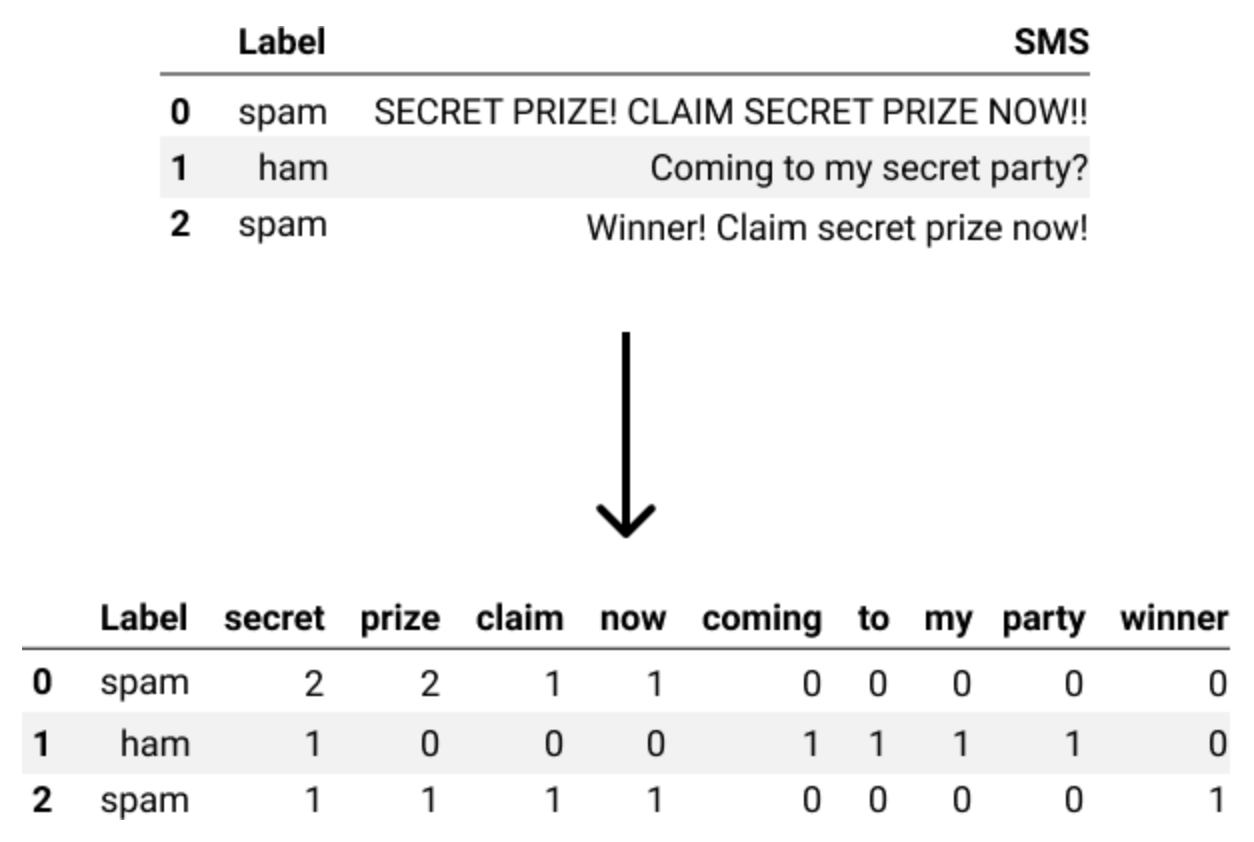


In [24]:
# Removing all the punctuation from the SMS column in both datasets.
train_data['SMS'] = train_data['SMS'].str.replace('\W',' ')
train_data['SMS'] = train_data['SMS'].str.lower()
train_data.head()

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


In [25]:
#Transforming each message from the SMS column into a list by:

# 1. Splitting the list at the space character.
train_data["SMS"] = train_data["SMS"].str.split()

#2. Creating an empty vocabulary list.
vocabulary = []

#3. Appending all words in the list to Vocabulary
for msg in train_data["SMS"]:
    for word in msg:
        vocabulary.append(word)

#4. Getting rid of all duplicate words in the Vocabulary list.
vocabulary = list(set(vocabulary))

In [26]:
len(vocabulary)

7783

In [27]:
word_counts_per_sms = {unique_word: [0] * len(train_data['SMS']) 
                       for unique_word in vocabulary}

for index, sms in enumerate(train_data['SMS']):
    for word in sms:
        word_counts_per_sms[word][index]+=1
        
word_counts = pd.DataFrame(word_counts_per_sms)
train_data_clean = pd.concat([train_data, word_counts], axis=1)
train_data_clean.head()

,Label,SMS,tiny,mnths,cricket,txting,meal,off,understand,hogidhe,...,frauds,brains,vinobanagar,wewa,regard,weed,lrg,60p,younger,genuine
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Calculating Constants First
We're now done with cleaning the training set, and we can begin creating the spam filter. The Naive Bayes algorithm will need to answer these two probability questions to be able to classify new messages:

$$
P(Spam | w_1,w_2, ..., w_n) \propto P(Spam) \cdot \prod_{i=1}^{n}P(w_i|Spam)
$$$$
P(Ham | w_1,w_2, ..., w_n) \propto P(Ham) \cdot \prod_{i=1}^{n}P(w_i|Ham)
$$
Also, to calculate P(wi|Spam) and P(wi|Ham) inside the formulas above, we'll need to use these equations:

$$
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}}
$$$$
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}}
$$
Some of the terms in the four equations above will have the same value for every new message. We can calculate the value of these terms once and avoid doing the computations again when a new messages comes in. Below, we'll use our training set to calculate:

P(Spam) and P(Ham)
NSpam, NHam, NVocabulary
We'll also use Laplace smoothing and set $\alpha = 1$.

In [28]:
#Isolating spam and ham msgs.
spam_msgs = train_data_clean[train_data_clean['Label']=='spam']
ham_msgs = train_data_clean[train_data_clean['Label']=='ham']

#n_spam and n_ham
n_words_per_spam_msg = spam_msgs["SMS"].apply(len)
n_spam = n_words_per_spam_msg.sum()
n_words_per_ham_msg = ham_msgs["SMS"].apply(len)
n_ham = n_words_per_ham_msg.sum()

#p_spam and p_ham
p_spam = len(spam_msgs)/ len(train_data_clean)
p_ham = len(ham_msgs)/ len(train_data_clean)

#n_vocabulary
n_vocabulary = len(vocabulary)

#Instantiating alpha to 1.
alpha = 1

In [29]:
#Initializing two dictionaries.
parameter_spam = {unique_word:0 for unique_word in vocabulary}
parameter_ham = {unique_word:0 for unique_word in vocabulary}

for word in vocabulary:
    n_word_given_spam = spam_msgs[word].sum()
    n_word_given_ham = ham_msgs[word].sum()
    
    p_word_given_spam = (n_word_given_spam+alpha)/(n_spam + alpha*n_vocabulary)
    p_word_given_ham = (n_word_given_ham+alpha)/(n_ham + alpha*n_vocabulary)
    
    parameter_ham[word] = p_word_given_ham
    parameter_spam[word] = p_word_given_spam
    




# Creating our Spam-filter.
Now its time to create the spam filter. The filter will be performing the following operations:
1. It takes an imput as a new message.
2. Calculates P(Spam|W1, W2,.., Wn) and P(Ham|W1, W2,..,Wn).
3. Compares the values of P(Spam|W1, W2,.., Wn) and P(Ham|W1, W2,..,Wn) and if:
    - If P(Spam|W1, W2,.., Wn) > P(Ham|W1, W2,..,Wn) then the message will be classified as Spam.
    - If P(Spam|W1, W2,.., Wn) < P(Ham|W1, W2,..,Wn) then the message will be classified as Ham(Non-Spam).
    - If P(Spam|W1, W2,.., Wn) = P(Ham|W1, W2,..,Wn) then the filter may request for human help.

In [30]:
import re

def classify(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()
    
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    
    for word in message:
        if word in parameter_spam:
            p_spam_given_message *= parameter_spam[word]
        if word in parameter_ham:
            p_ham_given_message *= parameter_ham[word]


    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')

In [31]:
classify("WINNER! This is the secret code to unlock the money: C3421.")

P(Spam|message): 1.3481290211300841e-25
P(Ham|message): 1.9368049028589875e-27
Label: Spam


In [32]:
classify("Sounds good, Tom, then see u there")

P(Spam|message): 2.4372375665888117e-25
P(Ham|message): 3.687530435009238e-21
Label: Ham


Success! Our spam filter works! 

# Measuring the accuracy of our spam filter.
Now it's time to use our spam filter on our 1,114 test data. This will determine how well the filter will classify the test data I have. I will start by writing the function designed to classify our dataset and then apply it to the dataset.

In [33]:
correct = 0
total = len(test_data)

def classify_test_set(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameter_spam:
            p_spam_given_message *= parameter_spam[word]

        if word in parameter_ham:
            p_ham_given_message *= parameter_ham[word]

    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'needs human classification'

In [34]:
test_data['predicted'] = test_data['SMS'].apply(classify_test_set)
test_data.head()

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


In [35]:
for row in test_data.iterrows():
    row = row[1]
    if row['Label'] == row['predicted']:
        correct += 1

print("Correct: ", correct)
print("Incorrect: ", total-correct)
print("Accuracy: ", round((correct/total)*100, 2))

Correct:  1100
Incorrect:  14
Accuracy:  98.74


My spam filter was able to correctly classify 1,100 messages in the test data set out of a total of 1,114. The accuracy of my spam filter is about 98.74% which is well over the 80% that I had originally hoped. But there is still for improvement. 

# Next Steps.
The next steps for this filter would be to analyze the filter and the training data sets to figure out why the filter incorrectly classsified the 14 messages. From there I can figure out the what modifications I can make to improve the filter accuracy to 100%. 